# Example of fitting PAT measurements

Authors: Pieter Eendebak, Sjaak van Diepen

For more information in the PAT fitting see "Automated tuning of inter-dot tunnel couplings in quantum dot arrays", https://arxiv.org/abs/1803.10352

Import the modules used in this program:

In [17]:
import os, sys
import qcodes
import scipy.constants
import matplotlib.pyplot as plt
import numpy as np

from qcodes import MatPlot
import qtt
from qtt.algorithms.tunneling import fit_pol_all, polmod_all_2slopes
from qtt.algorithms.pat_fitting import fit_pat, plot_pat_fit, pre_process_pat, show_traces, detect_peaks
%matplotlib inline  

## Load dataset

In [18]:
exampledatadir=os.path.join(qtt.__path__[0], 'exampledata')
qcodes.DataSet.default_io = qcodes.DiskIO(exampledatadir)
dataset_pat = qtt.data.load_dataset(os.path.join('2017-09-04', '11-05-17_qtt_scan2Dfastvec'))
dataset_pol = qtt.data.load_dataset(os.path.join('2017-09-04', '11-04-45_qtt_scan1Dfastvec'))

Set some parameters from the data.

In [8]:
la = 74.39 # lever arm
sweep_detun = {'P1': -1.1221663904980717, 'P2': 1.262974805193041}
kb = scipy.constants.k/(1e-6*scipy.constants.elementary_charge)  # [ueV/K], Boltzmann
Te = 98e-3*kb
ueV2GHz = 1e15*scipy.constants.h/scipy.constants.elementary_charge # [GHz/ueV]

Show the PAT scan and the background data.

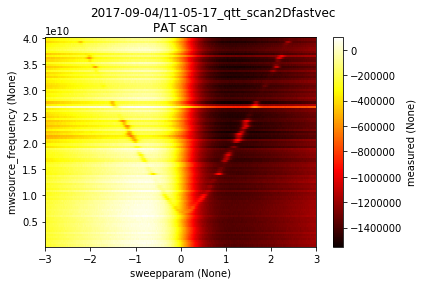

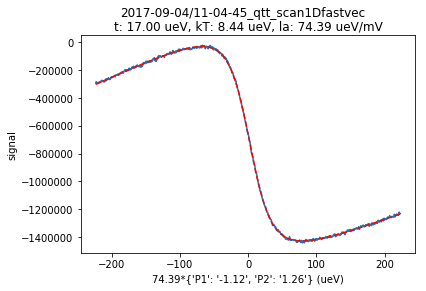

In [9]:
plt.figure(5); plt.clf()
MatPlot(dataset_pat.default_parameter_array(), num=5)
plt.title('PAT scan')

pol_fit, pol_guess = fit_pol_all(la*dataset_pol.sweepparam.ndarray, dataset_pol.measured1, kT=Te)  # 1 indicates fpga channel

fig_pol = plt.figure(10)
plt.plot(la*dataset_pol.sweepparam.ndarray, dataset_pol.measured1)
plt.plot(la*dataset_pol.sweepparam.ndarray, polmod_all_2slopes(la*dataset_pol.sweepparam.ndarray, pol_fit, kT=Te), 'r--')
plt.xlabel('%.2f*%s (ueV)' % (la,str({plg: '%.2f' % sweep_detun[plg] for plg in sweep_detun})))
plt.ylabel('signal')
plt.title('t: %.2f ueV, kT: %.2f ueV, la: %.2f ueV/mV' % (np.abs(pol_fit[0]), Te, la))
_=plt.suptitle(dataset_pol.location)

## Fit PAT model

In [10]:
x_data = dataset_pat.sweepparam.ndarray[0]
y_data = np.array(dataset_pat.mwsource_frequency)
z_data = np.array(dataset_pat.measured)
background = np.array(dataset_pol.default_parameter_array())

pp, pat_fit = fit_pat(x_data, y_data, z_data, background)
imq=pat_fit['imq']

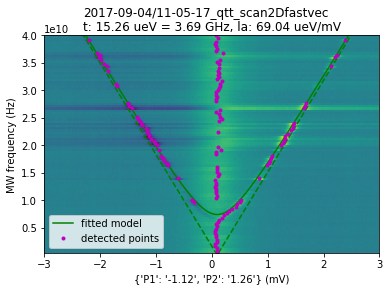

In [11]:
pat_fit_fig = plt.figure(100); plt.clf()
plot_pat_fit(x_data, y_data, imq, pp, fig=pat_fit_fig.number, label='fitted model')
plt.plot(pat_fit['xd'], pat_fit['yd'], '.m', label='detected points')
plt.title('t: %.2f ueV = %.2f GHz, la: %.2f ueV/mV' % (np.abs(pp[2]), np.abs(pp[2]/ueV2GHz), pp[1]))
plt.suptitle(dataset_pat.location)
plt.xlabel('%s (mV)' % str({plg: '%.2f' % sweep_detun[plg] for plg in sweep_detun}))
plt.ylabel('MW frequency (Hz)')
_=plt.legend()

## Fit 2-electron model

In [13]:
dataset_pat = qcodes.load_data(r'misc\2electron_pat_26102017\pat')
dataset_pol = qcodes.load_data(r'misc\2electron_pat_26102017\background')

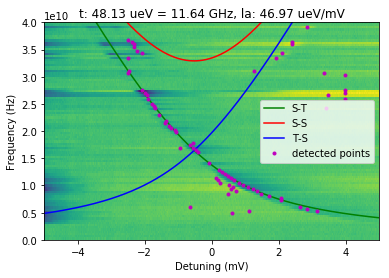

In [14]:
x_data = dataset_pat.sweepparam.ndarray[0]
y_data = np.array(dataset_pat.mwsource_frequency)
z_data = np.array(dataset_pat.measured)
background = np.array(dataset_pol.default_parameter_array())

pp, pat_fit = fit_pat(x_data, y_data, z_data, background, trans='two_ele', even_branches=[True, False, False])
imq=pat_fit['imq']

pat_fit_fig = plt.figure(100); plt.clf()
plot_pat_fit(x_data, y_data, imq, pp, fig=pat_fit_fig.number, label='fitted model', trans='two_ele')
plt.plot(pat_fit['xd'], pat_fit['yd'], '.m', label='detected points')
plt.title('t: %.2f ueV = %.2f GHz, la: %.2f ueV/mV' % (np.abs(pp[2]), np.abs(pp[2]/ueV2GHz), pp[1]))
_=plt.legend()

## Show pre-processing and intermediate steps

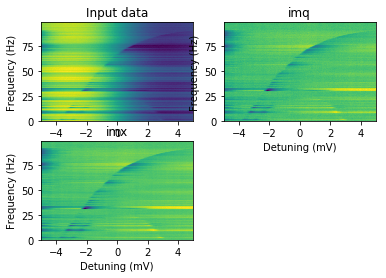

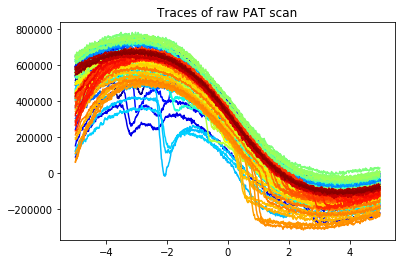

In [15]:
imx, imq, _ = pre_process_pat(x_data, y_data, background, z_data, fig=100)
show_traces(x_data, z_data, fig=101, direction='h', title='Traces of raw PAT scan')

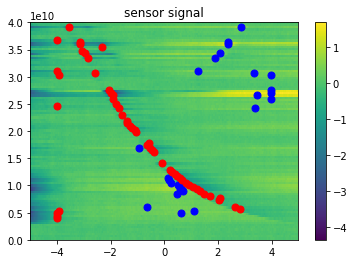

In [16]:
trans='one_ele'
period=1e-3 # period needed?

xx, weights, dpresults = detect_peaks(x_data, y_data, imx, model=trans, period=period, sigmamv=.05, fig=200)